## 3. Methods

Paper: Section 1

In this notebook, we check the HOD profile of the Buzzard v2.0.0 simulation

###  Buzzard halo sample: M200 

cat: input cluster catalog

columns: <br>
Z - redshift <br>
M200 - critical mass <br>
N195 - number of galaxies inside r200 within Mr-5log(h)<= -19.5

In [1]:
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
import os

from astropy.table import Table, vstack
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(color_codes=True)
plt.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1.3)

In [2]:
def getIndices(gindices,gkeys,ckeys):
    indicies = np.empty((0),dtype=int)
    indicies_into_cluster = np.empty((0),dtype=int)

    for i in range(ckeys.size):
        idx, = np.where(gkeys==ckeys[i])
        if idx.size>0:
            w2 = np.arange(gindices[idx],gindices[idx+1], 1, dtype=int)
            w = np.full(w2.size,i,dtype=int)

            indicies = np.append(indicies,w2)
            indicies_into_cluster = np.append(indicies_into_cluster,w)

    return indicies,indicies_into_cluster

In [50]:
filec = '/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/buzzard_v2.0.0_hod_halos.fits'
cat = Table(getdata(filec))

In [73]:
mask = np.logical_not(cat['bad'])
mask&= (cat['Z']<=0.9)
cat = cat[mask]

In [ ]:
np.count_nonzero(cat['sample'])

In [115]:
zcls = cat["Z"]
m200c= cat["M200"]        ## critical mass
m200v= cat['halo_mass']   ## virial mass
r200 = cat["R200"]

n19 = cat["N190"]
n195 = cat["N195"]
n20 = cat["N200"]
n205 = cat["N205"]

Text(0,0.5,'$M_{200,c} \\; [M_{\\odot}/h]$')

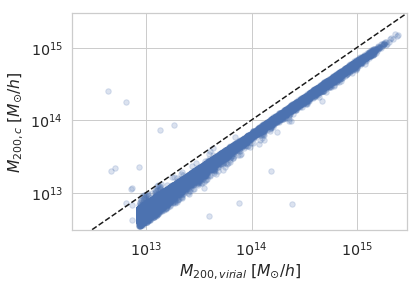

In [117]:
plt.plot([2e12,3e15],[2e12,3e15],'k--')
plt.scatter(m200v,m200c,s=30,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e12,3e15)
plt.ylim(3e12,3e15)
plt.xlabel(r'$M_{200,virial} \; [M_{\odot}/h]$')
plt.ylabel(r'$M_{200,c} \; [M_{\odot}/h]$')


In [118]:
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.special import erf

h=0.7
cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24


#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

def convertM200toR200(M200,z):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = rhoc(z)
    R200 = ( M200/(200*4*np.pi*rho/3) )**(1/3.)
    return R200/h

In [119]:
#Mass-richness relation functions (see Tinker et al 2011)
def ncen(M,log_Mmin,sigma):
    #takes logM_min and logSigma_logM from paper. returns Ncentral from paper
    sigma=10**sigma
    return (1./2.)*(1+erf((np.log10(M)-log_Mmin)/sigma))

def ntot(M,Msat,log_Mmin,sigma,alpha_sat,Mcut):
    #takes logMmin, logSigma_logM, logMsat, logMcut from paper. Returns Ntotal=Ncentral+Nsatellite from paper
    Msat=10**Msat
    Mcut=10**Mcut
    return ncen(M,log_Mmin,sigma)*(1+(((M/Msat)**alpha_sat)*np.exp(-Mcut/M)))

#Msat redshift dependence 
def logMsat(z,M0=12.33,a=-0.27):
    return M0 + a*z

#alpha_sat redshift dependence - currently used for redshift varying HOD model
def alpha_sat(z,alpha0=1.0,a=0.0,z0=0.5):
    if z> z0: 
        return alpha0 + a*(z-z0) #+ (alpha0+a*z)
    else: 
        return alpha0

def hod_mass_z(Ngals, z_cls, params,vec=False):
    ''' description: it computes the m200,c for the Tinker et al. 2012 Model
        input: Number of member galaxies along the cluster radius, cluster redshift and model paramenters.
        output: m200c
    '''
    #params: logMmin,logMsat,alphasat,logMcut,logsigmalogM directly from table 4 of paper
    # Tinker et al. 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1104.1635)
    
    Mmin=params[0]
    Msat=params[1]
    alpha=params[2]
    Mcut=params[3]
    sigma=params[4]

    mass = np.logspace(10,16,num=60,dtype=float)
    m200c = np.zeros_like(Ngals)
    
    Msat = logMsat(z_cls, params[1], 0.) # make msat to be a function of z
    #alpha=alpha_sat(z[i],params[2],-0.5,0.4) # make alpha a functin of z
    alpha=alpha_sat( z_cls, params[2]) # fixed alpha
    m=interp1d( ntot(mass,Msat,Mmin,sigma,alpha,Mcut), mass, bounds_error=False,fill_value='extrapolate')
    
    if vec:
        for i in range(len(Ngals)): Ngals[i]=max(Ngals[i],0.1) #set minimum value for mass conversions to prevent code from failing
    
    m200c=m(Ngals)

    return m200c


In [120]:
## Mr<-19.5
## logMmin,logMsat,alphasat,logMcut,logsigmalogM directly from table 4 of 
# params = [11.59,13.,1.01,12.08,-0.09]#parameters for mass conversion - see table 4 
params = [11.59,12.94,1.01,12.48,-0.69]

mass_hod = np.array([hod_mass_z(ni,zi,params) for ni,zi in zip(n195,zcls)]) 
r200_hod_mass = convertM200toR200(mass_hod*h,zcls)

#calculate mass given ngals (see above functions)
ngal_vec = np.arange(0.01,np.nanmax(n19)+1,.2)
zcls_vec = 0.45*np.ones_like(ngal_vec)
mass_vec = np.array([hod_mass_z(ni,zi,params) for ni,zi in zip(ngal_vec,zcls_vec)]) #calculate mass given ngals (see above functions)


In [121]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

def splitBins(var):
    nmin = np.nanmin(var)
    n1 = np.percentile(var,10)
    n2 = np.percentile(var,20)
    n3 = np.percentile(var,30)
    n4 = np.percentile(var,40)
    n5 = np.percentile(var,50)
    n6 = np.percentile(var,60)
    n7 = np.percentile(var,70)
    n8 = np.percentile(var,80)
    n9 = np.percentile(var,90)
    nmax = np.max(var)
    
    return np.array([nmin,n1,n2,n3,n4,n5,n6,n7,n8,n9,nmax])

In [122]:
mcuts=[19.5,20.,20.5]
labels = [r'$ M_{r} < -%.1f$'%mc for mc in mcuts]
def plot_diff_cuts():
    n195b = np.array([np.nanmean(n195[idx]) for idx in keys])
    n195b_std = np.array([np.nanstd(n195[idx]) for idx in keys])

    n20b = np.array([np.nanmean(n20[idx]) for idx in keys])
    n20b_std = np.array([np.nanstd(n20[idx]) for idx in keys])

    n205b = np.array([np.nanmean(n205[idx]) for idx in keys])
    n205b_std = np.array([np.nanstd(n205[idx]) for idx in keys])

    plt.figure(figsize=(8,6))
    plt.loglog(mass_vec,ngal_vec,'r--',label='HOD Model: $M_r < -19.5$')
    
    plt.errorbar(m200b,n205b,xerr=m200b_std,yerr=n205b_std,color='#AED6F1',fmt='o',label=labels[2])
    plt.errorbar(m200b,n20b,xerr=m200b_std,yerr=n20b_std,color='#3498DB',fmt='o',label=labels[1])
    plt.errorbar(m200b,n195b,xerr=m200b_std,yerr=n195b_std,color='#1B4F72',fmt='o',label=labels[0])

    plt.ylim(0.05,3*np.nanmax(n195))
    plt.xlim(1e11,3e15)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$N_{200}$')
    plt.xlabel(r'$M_{200,c} \; [M_{\odot}/h]$')
    # plt.xticks([3e14,7e14,1e15,3e15])
    plt.legend()
    

In [123]:
mass_bins = np.logspace(12,np.log10(np.max(m200c)),11)
keys, m200b = makeBins(m200c,mass_bins)
m200b_std = np.diff(mass_bins)/2

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


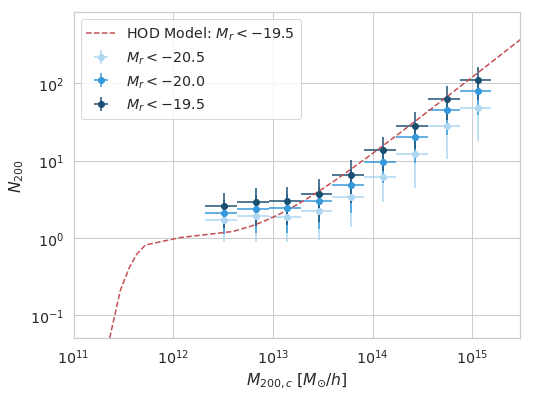

In [124]:
plot_diff_cuts()
plt.savefig('hod_model_buzzard_diff_mag_cuts_fixed.png')

In [125]:
zcuts=np.linspace(0.1,0.9,5)
labels = [r'$ %.2f < z \leq %.2f$'%(zl,zh) for zl,zh in zip(zcuts[:-1],zcuts[1:])]
clist = ['#1B4F72','#2471A3','#5DADE2','#AED6F1']

# zcuts=np.array([0.7,0.8,0.9])
# labels = [r'$ %.2f < z \leq %.2f$'%(zl,zh) for zl,zh in zip(zcuts[:-1],zcuts[1:])]
# clist = ['#1B4F72','#5DADE2']

def plot_zbins():
    plt.figure(figsize=(8,6))
    plt.loglog(mass_vec,ngal_vec,'r--',label='HOD Model: $M_r < -19.5$')

    i=0
    for zl,zh in zip(zcuts[:-1],zcuts[1:]):
        mask = (zcls<=zh)&(zcls>zl)
        n195b = np.array([np.nanmean(n195[idx][mask[idx]]) for idx in keys])
        n195b_std = np.array([np.nanstd(n195[idx][mask[idx]]) for idx in keys])
        
        plt.errorbar(m200b,n195b,xerr=m200b_std,yerr=n195b_std,color=clist[i],fmt='o',label=labels[i])
        i+=1
        
    plt.ylim(0.05,3*np.nanmax(n195))
    plt.xlim(1e11,3e15)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$N_{200}$')
    plt.xlabel(r'$M_{200,c} \; [M_{\odot}/h]$')
    # plt.xticks([3e14,7e14,1e15,3e15])
    plt.legend()
    

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


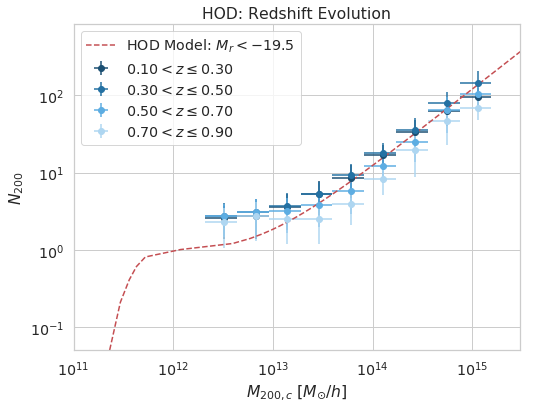

In [126]:
plot_zbins()
plt.title('HOD: Redshift Evolution')
plt.savefig('hod_model_buzzard_zbins.png')